# Gastrulatio E82585 - Waddington OT

# Imports and settings

In [13]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import wot
import scanpy as sc
import scvelo as scv
import cellrank as cr
import anndata as ad
from cellrank.external.kernels import WOTKernel
from cellrank.estimators import GPCCA

In [14]:
cr.logging.print_versions()

cellrank==1.5.1+g525b847 scanpy==1.9.1 anndata==0.8.0 numpy==1.23.5 numba==0.56.4 scipy==1.10.0 pandas==1.5.2 pygpcca==1.0.4 scikit-learn==1.2.0 statsmodels==0.13.5 scvelo==0.2.5 pygam==0.8.0 matplotlib==3.6.2 seaborn==0.12.2


# Data Loading and preprocessing

In [15]:
adata825 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/gastrulation/stage_825_growth_rate.h5ad")
adata85 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/gastrulation/stage_85_growth_rate.h5ad")
adata = ad.concat([adata825, adata85], merge = 'same')

leave_in_cell = ['Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']
adata = adata[adata.obs["celltype"].isin(leave_in_cell)].copy()

sc.pp.log1p(adata)

adata.obs = adata.obs.loc[:, ['stage', 'celltype']]
adata.var = adata.var.loc[:, ['highly_variable']]

adata.obs['celltype'] = pd.Series(adata.obs['celltype'], dtype='category')

# Transport matrix

In [16]:
wk = WOTKernel(adata, time_key="stage")
wk.compute_initial_growth_rates(organism="mouse", key_added="growth_rate_init")
wk.compute_transition_matrix(
    growth_iters=3, growth_rate_key="growth_rate_init"
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:35<00:00, 35.02s/time pair]


WOTKernel[n=4645, cost_matrices=None, lambda1=1, lambda2=50, epsilon=0.05, growth_iters=3, solver='duality_gap', growth_rate_key='growth_rate_init', threshold='auto', self_transitions='connectivities']

# Macrostate computation

In [17]:
g = GPCCA(wk)

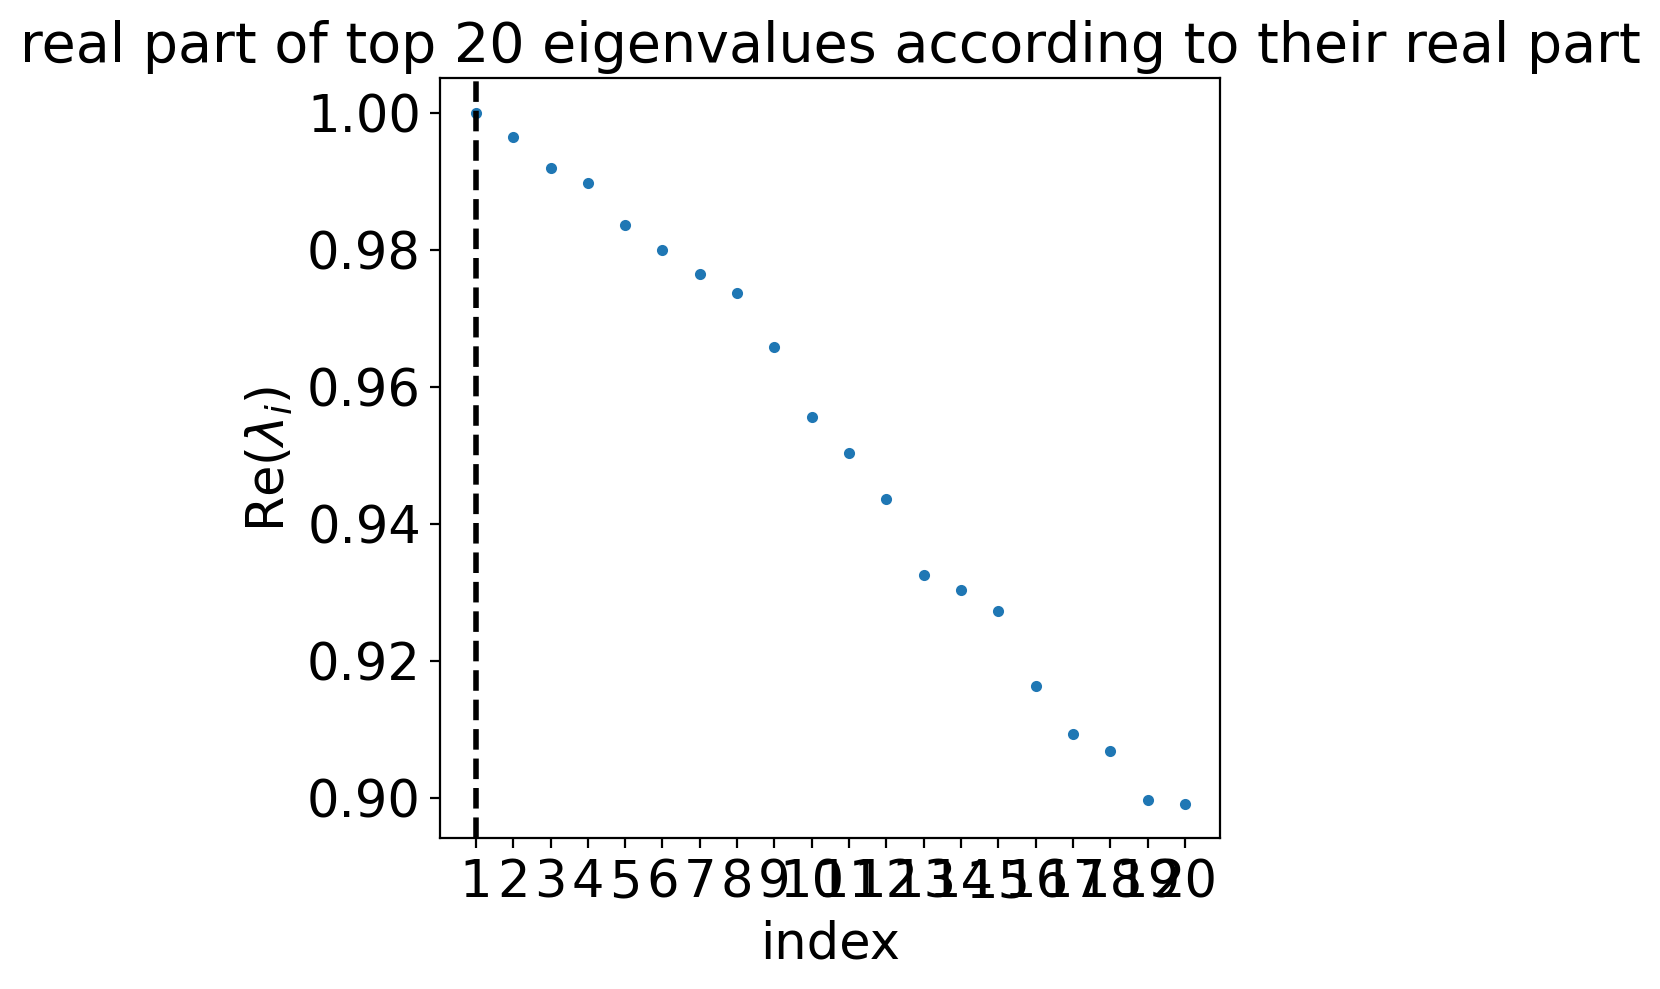

In [18]:
g.compute_schur(n_components=20)
g.plot_spectrum(real_only=True)

/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/scatter.py:614: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(


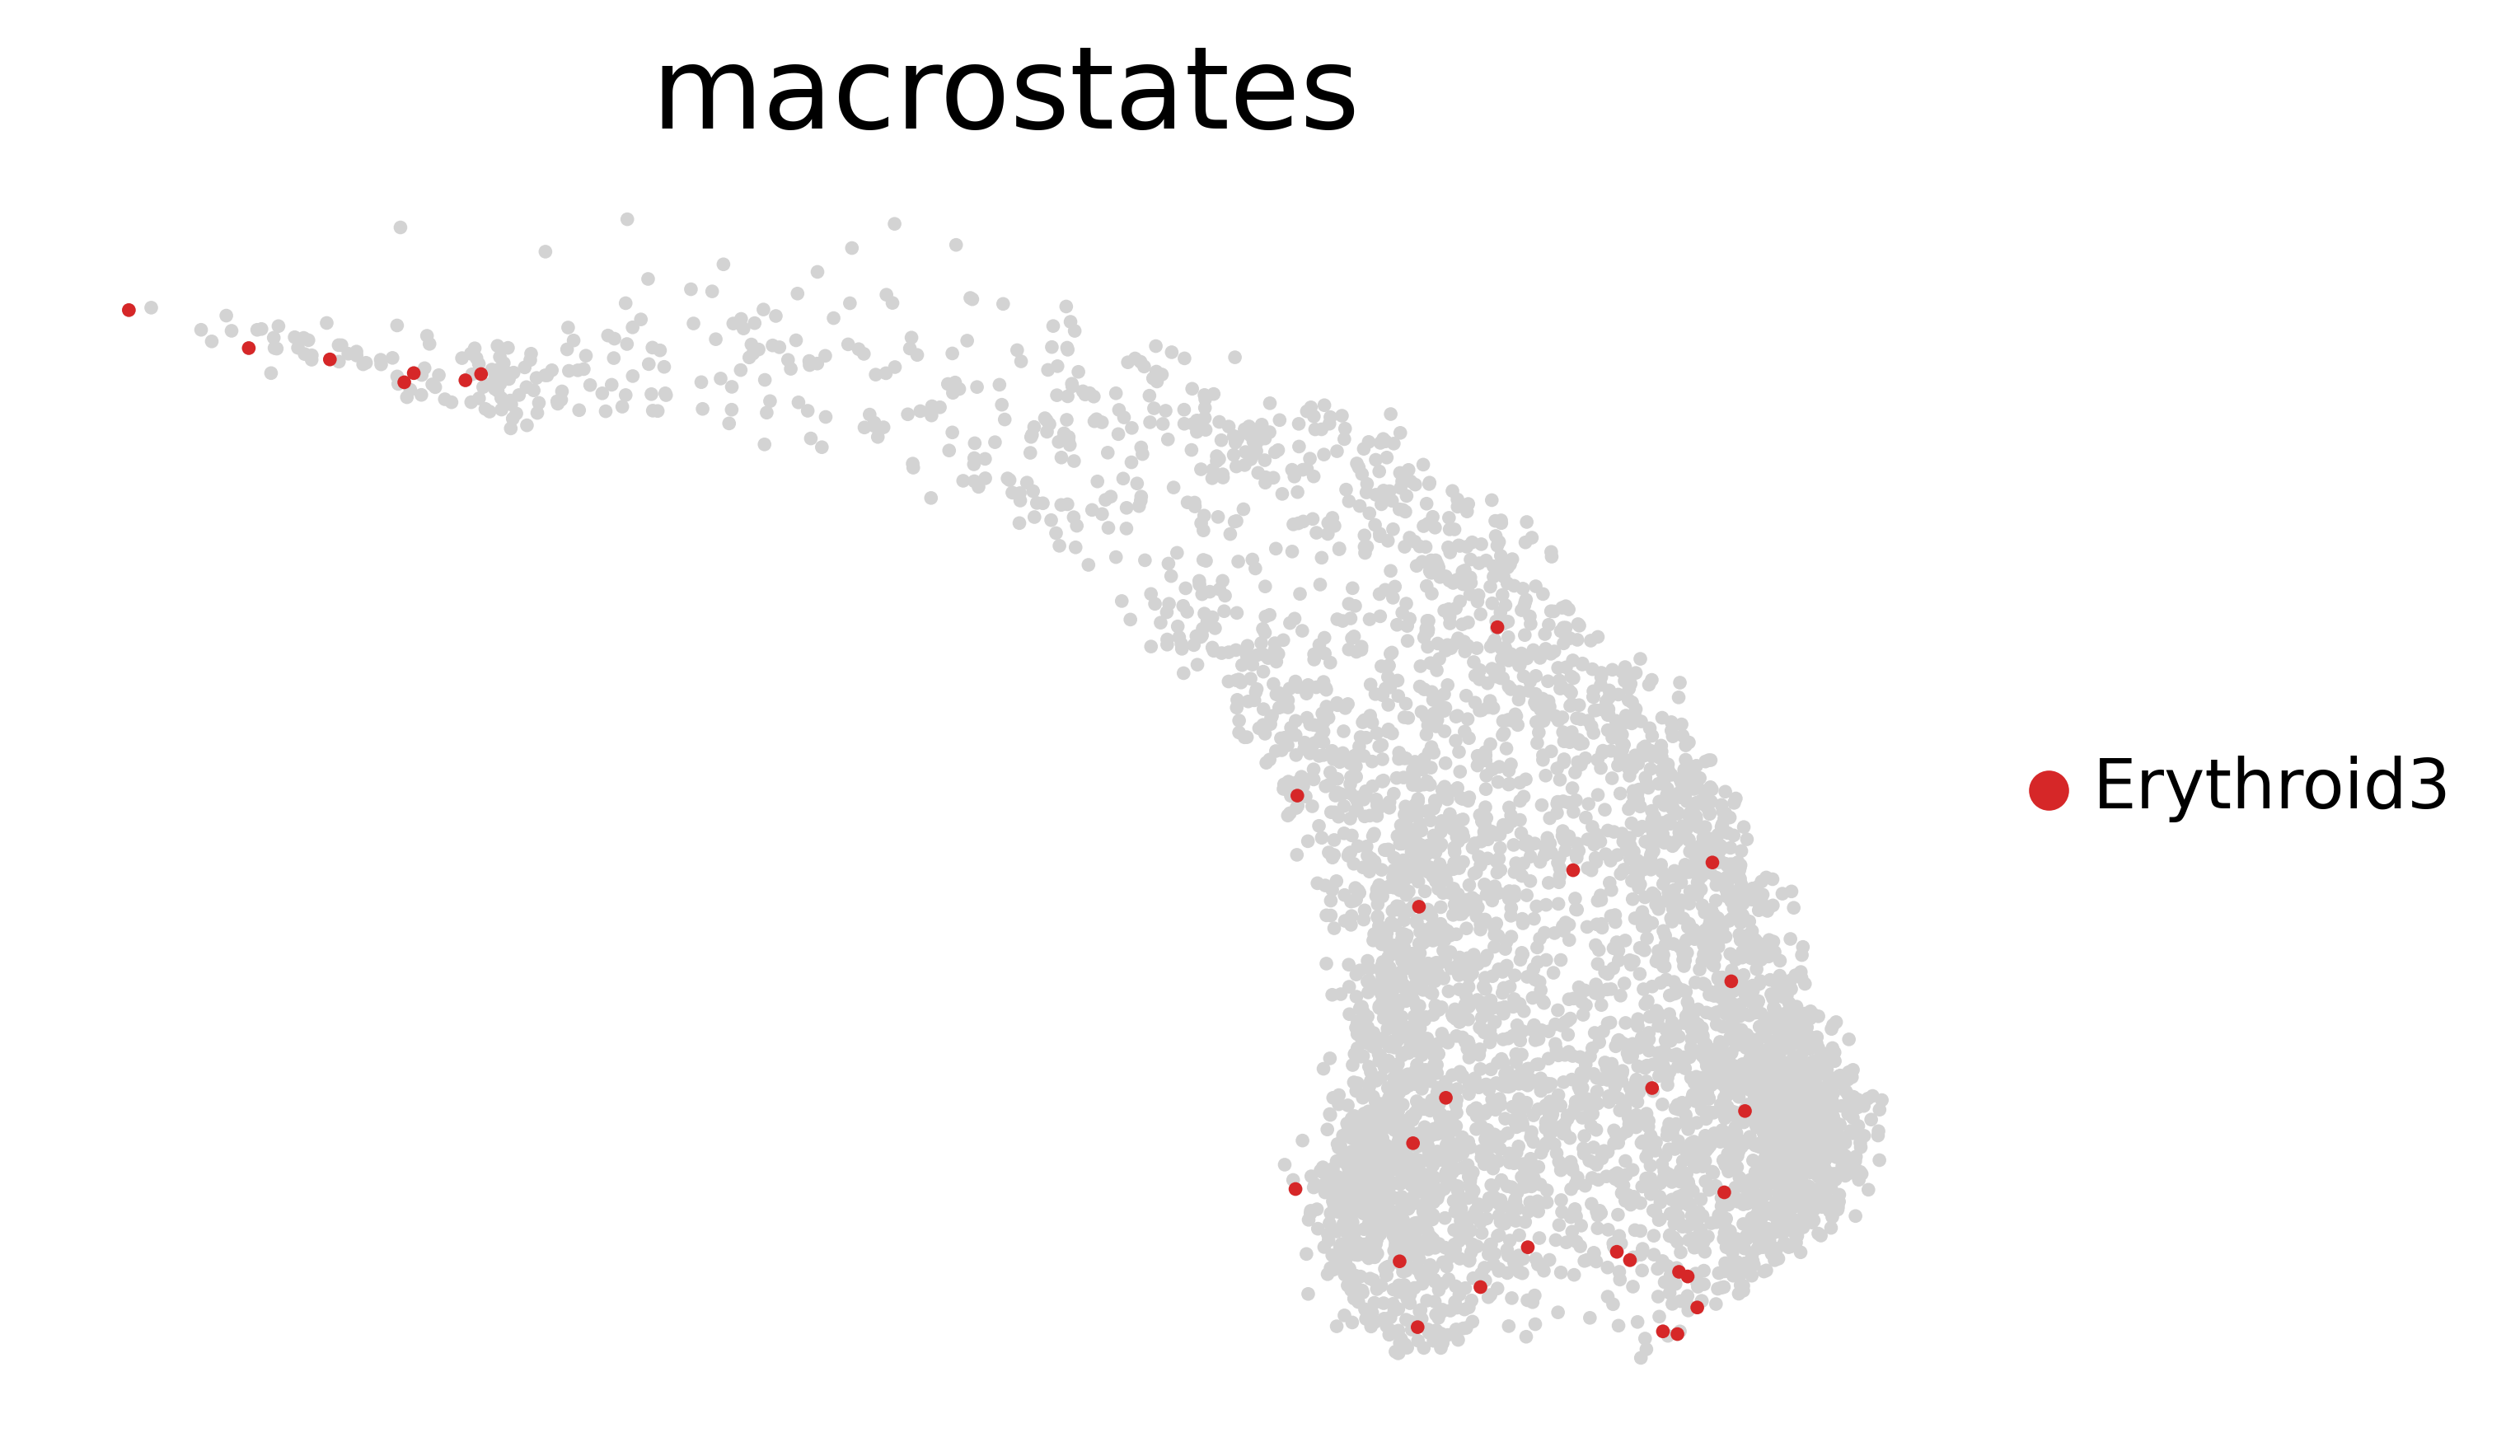

In [19]:
g.compute_macrostates(n_states=1, cluster_key="celltype")
scv.set_figure_params('scvelo', transparent=True, fontsize=20, color_map='viridis')
g.plot_macrostates(discrete=True, basis="umap", legend_loc="right", legend_fontweight='normal', legend_fontsize='12', dpi=250)

# Fate probabilities

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65/s]
/home/icb/jonas.flor/miniconda3/envs/neuralBenchmark_moscot/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


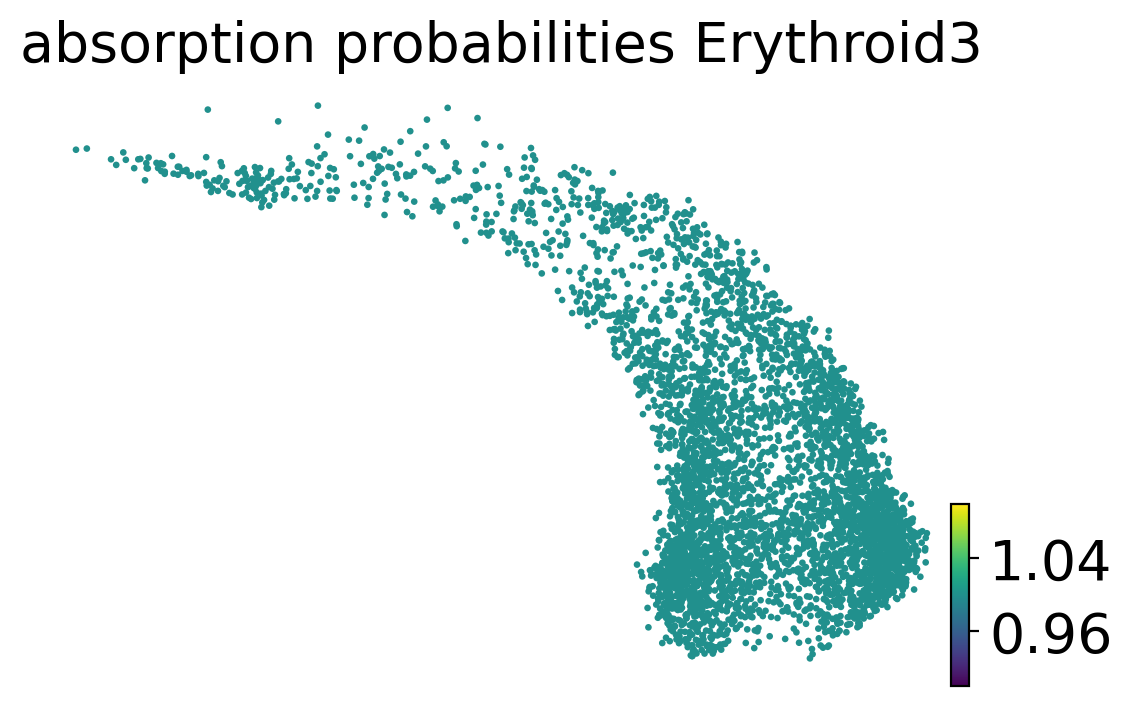

In [20]:
g.set_terminal_states_from_macrostates(
    [
        'Erythroid3'
    ]
)
g.compute_absorption_probabilities(solver="gmres", use_petsc=True, tol=1e-12, preconditioner='ilu')
g.plot_absorption_probabilities(same_plot=False, basis="umap", perc=[0, 99], ncols=2)

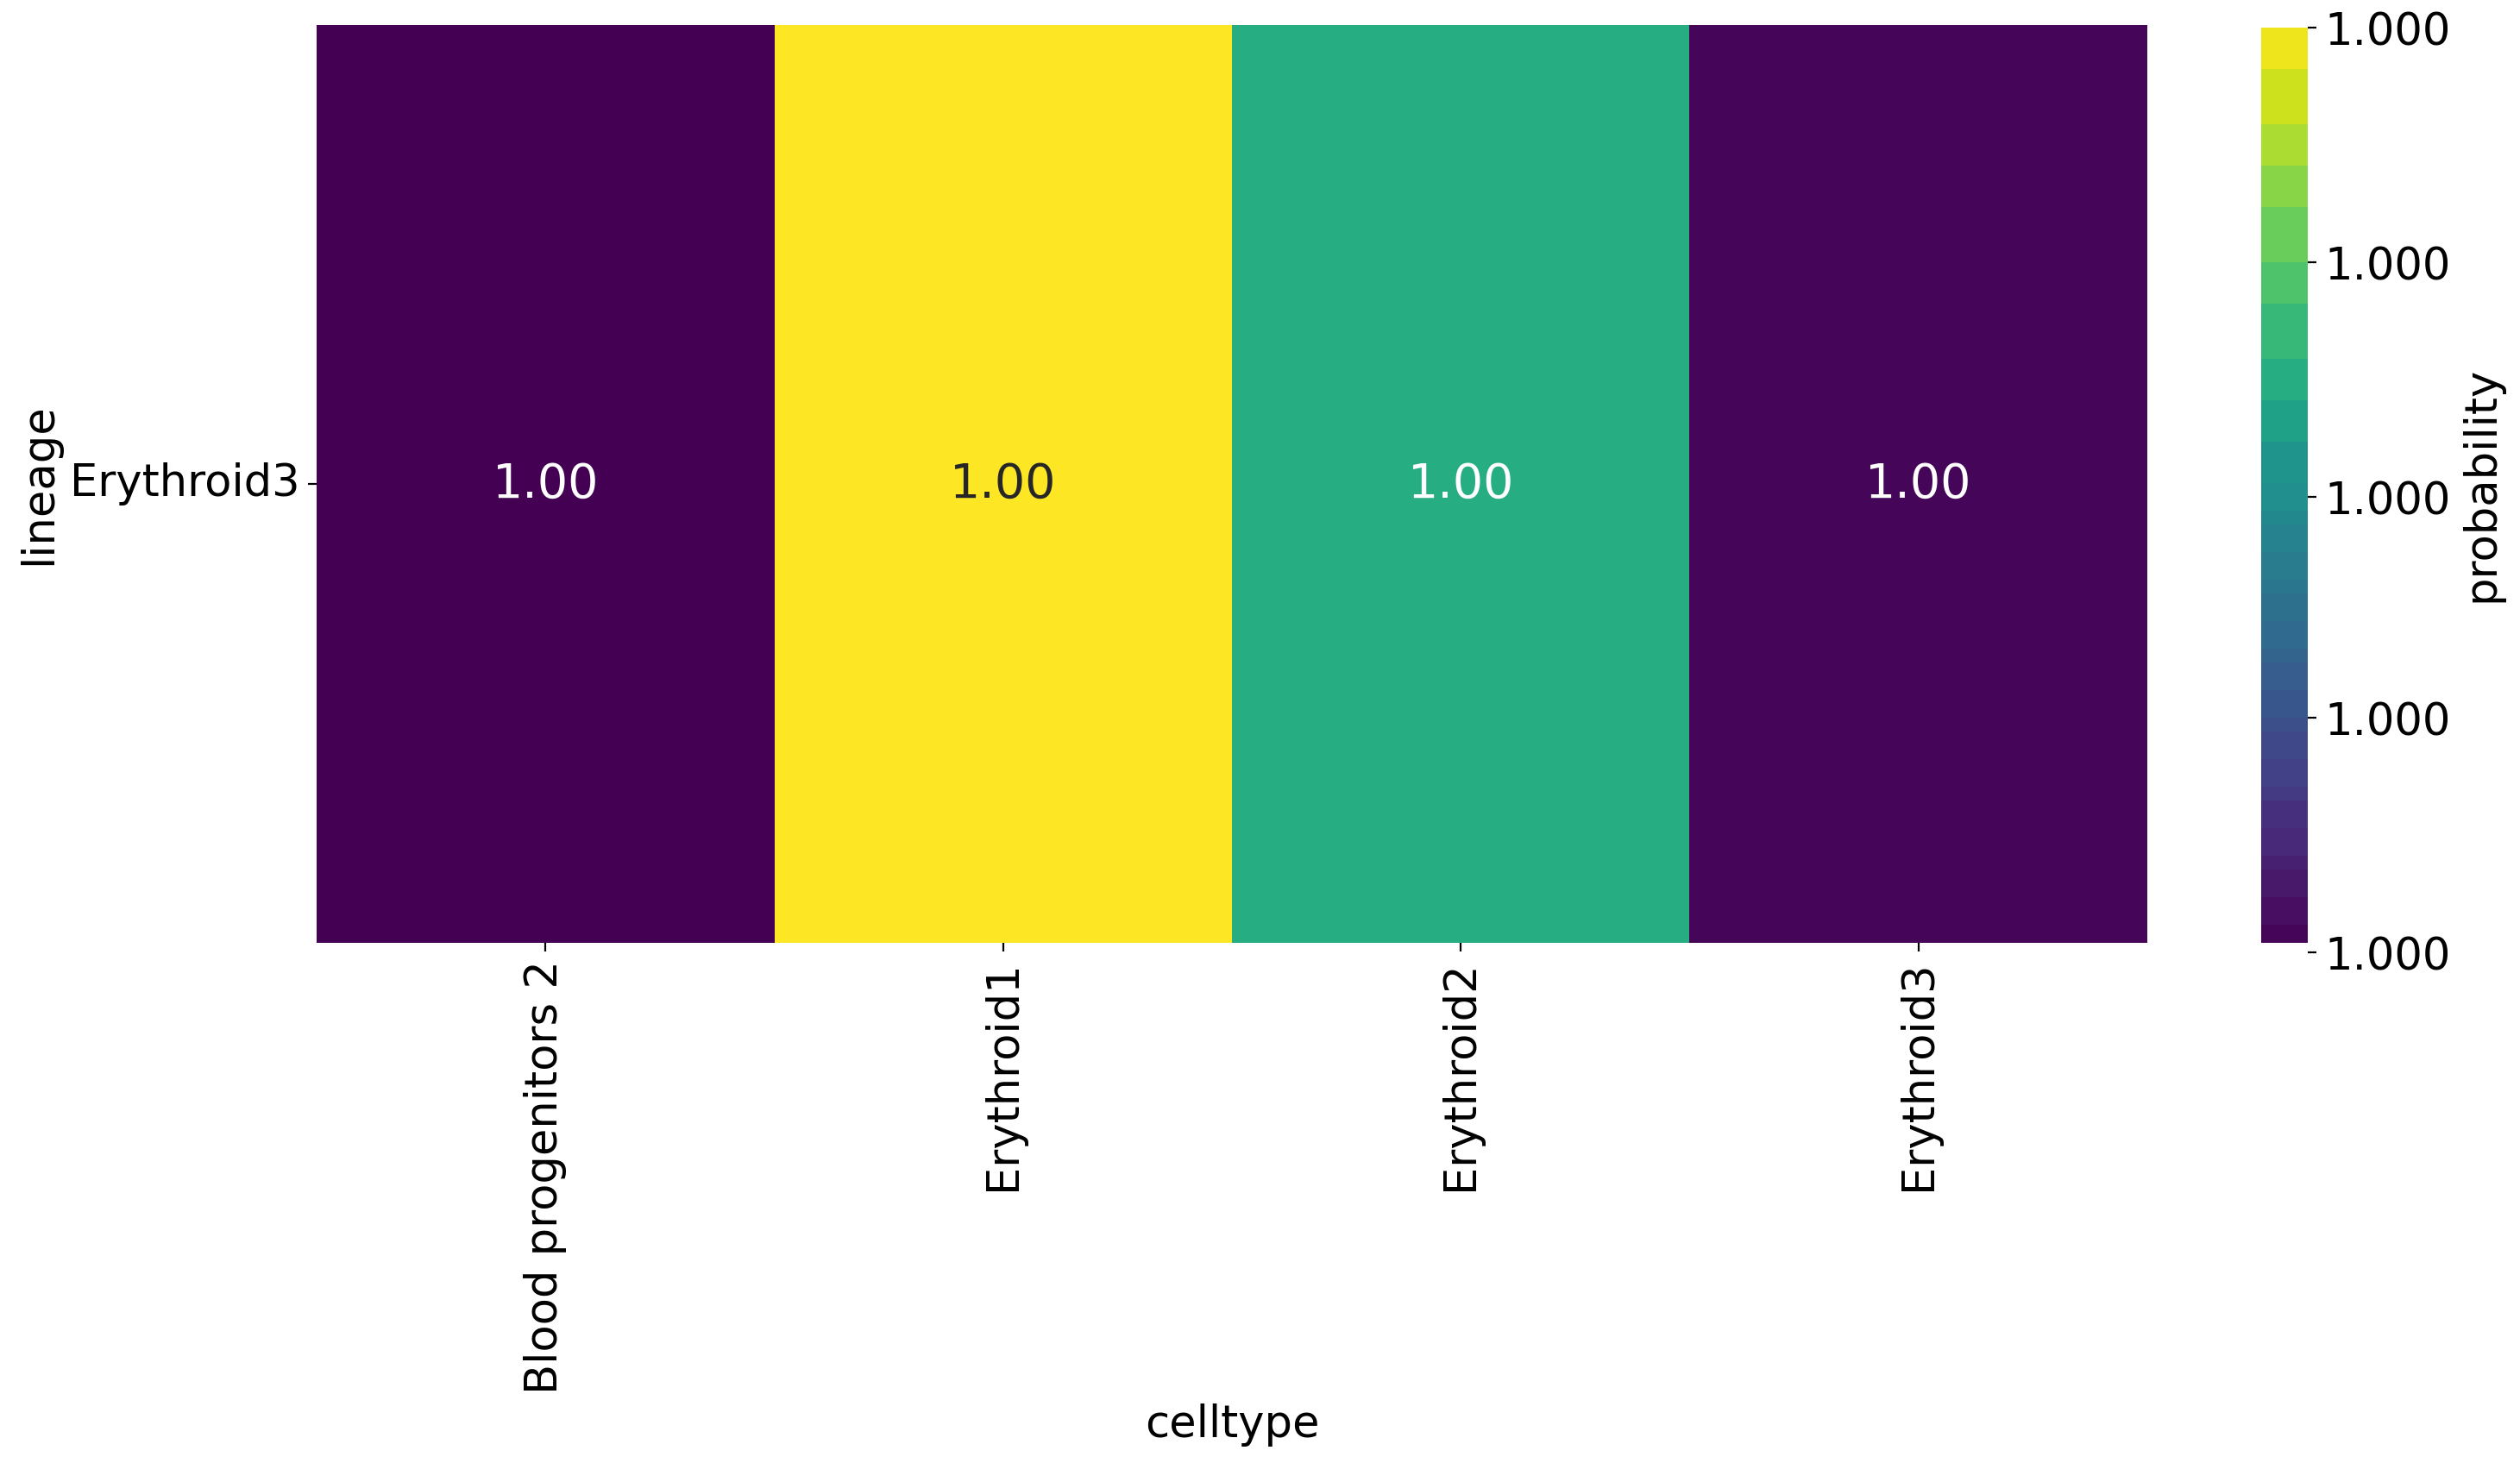

In [21]:
cr.pl.aggregate_absorption_probabilities(
    adata,
    mode='heatmap',
    lineages=['Erythroid3'],
    cluster_key='celltype',
    clusters=['Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3'],
    figsize=(17, 7),
    title="",
    #save="transprobs_wot.png"
)

In [22]:
cluster = ['Blood progenitors 2', 'Erythroid1', 'Erythroid2', 'Erythroid3']
terminal_cluster = ['Erythroid3']

aggregated_absorption_prob = np.empty((len(terminal_cluster), len(cluster)))
data = g.absorption_probabilities.X
sums = np.sum(data, axis=0)
tmp = adata.obs['celltype']

for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = np.dot(np.array((tmp.array==cluster[i]).astype(int)),data)
for i in range(len(cluster)):
    aggregated_absorption_prob[:,i] = aggregated_absorption_prob[:,i]/np.sum(aggregated_absorption_prob[:,i])
df = pd.DataFrame(aggregated_absorption_prob)
df.index = terminal_cluster
df.columns = cluster

In [23]:
correct_transitions = [('Erythroid3', 'Blood progenitors 2'), ('Erythroid3', 'Erythroid1'),
                       ('Erythroid3', 'Erythroid2'), ('Erythroid3', 'Erythroid3')]

sum_prob = 0
for i in correct_transitions:
    sum_prob = sum_prob + df.loc[i]
mean_prob = sum_prob/len(cluster)
mean_prob

1.0